# Определение перспективного тарифа для телеком компании
# Описание проекта
Заказчик «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: `«Смарт»` и `«Ультра»`. Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.  

**Описание тарифов**  
Тариф `«Смарт»`  
Ежемесячная плата: 550 рублей  
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:  
минута разговора: 3 рубля  
сообщение: 3 рубля  
1 Гб интернет-трафика: 200 рублей  

Тариф `«Ультра»`  
Ежемесячная плата: 1950 рублей  
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:  
минута разговора: 1 рубль  
сообщение: 1 рубль  
1 Гб интернет-трафика: 150 рублей  

*«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.*

# Описание данных
Таблица `users` (информация о пользователях):  
*user_id* — уникальный идентификатор пользователя;
*first_name* — имя пользователя;
*last_name* — фамилия пользователя;
*age* — возраст пользователя (годы);
*reg_date* — дата подключения тарифа (день, месяц, год);
*churn_date* — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных);
*city* — город проживания пользователя;
*tariff* — название тарифного плана.

Таблица `calls` (информация о звонках):  
*id* — уникальный номер звонка;
*call_date* — дата звонка;
*duration* — длительность звонка в минутах;
*user_id* — идентификатор пользователя, сделавшего звонок.

Таблица `messages` (информация о сообщениях):  
*id* — уникальный номер сообщения;
*message_dat* — дата сообщения;
*user_id* — идентификатор пользователя, отправившего сообщение.

Таблица `internet` (информация об интернет-сессиях):  
*id* — уникальный номер сессии;
*mb_used* — объём потраченного за сессию интернет-трафика (в мегабайтах);
*session_date* — дата интернет-сессии;
*user_id* — идентификатор пользователя.

Таблица `tariffs` (информация о тарифах):  
*tariff_name* — название тарифа;
*rub_monthly_fee* — ежемесячная абонентская плата в рублях;
*minutes_included* — количество минут разговора в месяц, включённых в абонентскую плату;
*messages_included* — количество сообщений в месяц, включённых в абонентскую плату;
*mb_per_month_included* — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах);
*rub_per_minute* — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата);
*rub_per_message* — стоимость отправки сообщения сверх тарифного пакета;
*rub_per_gb* — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта).

# План работы   
1. **[Предобработка](#1)**
    - Объединение датасетов
    - Поиск аномалий
    - Добавление признаков: помесячная выручка и расходы по месяцам для каждого пользователся
2. **[Анализ](#2)**
    - Исследование поведения клиентов
3. **[Проверка гипотез](#3)**
    - Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
    - Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
4. **[Выводы](#4)**  

### Бибилиотеки

In [1]:
from pathlib import Path

import pandas as pd

# statistics
import numpy as np
from scipy import stats as st

# graphics
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(rc={'figure.figsize':(12,3)})

# dates
from datetime import datetime, timedelta
import datetime as dt

### Функции

Категоризация

In [2]:
def group_city(cell):
    '''
    Takes name of the city and return one of the 3 groups: Москва, Санкт-Петербург или другие.
    '''
    
    if 'Москва' in cell:
        return 'Москва'
    if 'Санкт-Петербург' in cell:
        return 'Санкт-Петербург'
    
    return 'другие'

У каждого пользователя своя точка отсчета, и следовательно свой расчетный месяц.     
Функция выделяет этот расчетный месяц.

In [3]:
def billing_month(row):
    '''
    Takes row with columns 'reg_date' - starting point, 'date' - date when used. 
    Esimated billing period is 30 days.
    Return billing month of this date.
    '''
    
    start = datetime.strptime(row['reg_date'], '%Y-%m-%d')
    month = datetime.strptime(row['reg_date'], '%Y-%m-%d').month
    while datetime.strptime(row['date'], '%Y-%m-%d') >= (start + dt.timedelta(days=30)):
        start = start + dt.timedelta(days=30)
        month +=1
        
    return month


def test_revenue_month():
    '''
    2 tests for function billing_period()
    '''
    # test 1
    sample_d = {'user_id': ['1000'], 
         'reg_date': ['2018-05-25'], 
         'date': ['2018-06-27']}
    sample_df = pd.DataFrame(data=sample_d)
    sample_df['period'] = sample_df.apply(period, axis=1)
    
    if sample_df.loc[0, 'period'] == 6:
        print('test1 - ok')
    else:
        print('test1 - fail')
        return sample_df
    
    # test 2
    sample_d = {'user_id': ['1000', '1000','1200'], 
         'reg_date': ['2018-05-25', '2018-05-25', '2018-06-25'], 
         'date': ['2018-06-05', '2018-08-29', '2018-09-23'], 
         'calls_duration': ['550', '20','20']}
    sample_df = pd.DataFrame(data=sample_d)
    sample_df['period'] = sample_df.apply(period, axis=1)
    
    if sample_df.loc[0, 'period'] == 5 and sample_df.loc[1, 'period'] == 8 and sample_df.loc[2, 'period'] == 9:
        print('test2 - ok')
    else:
        print('test2 - fail')
        return sample_df

Выручка      
- Вычетаем бесплатный лимит из суммарного кол-ва израсходованных минут, сообщений и интернет-трафика; 
- Остаток умножаем на значение из тарифного плана; 
- Прибавляем абонентскую плату, соответствующую тарифному плану.

In [4]:
def calculate_revenue(row):
    
    '''
    Takes rows with columns 'calls_duration', 'messages', 'mb_used' и 'tariff' and return revenue.
    All information about tariff takes from 'tariff_dict' dictionary
    Internet overrun rounds to Gb.
    '''
    
    if row['calls_duration'] <= tariff_dict['minutes_included'][row['tariff']]:
        extra_min = 0
    else:
        extra_min = row['calls_duration'] - tariff_dict['minutes_included'][row['tariff']]
    
    if row['messages'] <= tariff_dict['messages_included'][row['tariff']]:
        extra_mess = 0
    else:
        extra_mess = row['messages'] - tariff_dict['messages_included'][row['tariff']]
    
    if row['mb_used'] <= tariff_dict['mb_per_month_included'][row['tariff']]:
        extra_mb = 0
    else:
        extra_mb = (row['mb_used'] - tariff_dict['mb_per_month_included'][row['tariff']]) // 1024 + 1
    
    return (extra_min * tariff_dict['rub_per_minute'][row['tariff']] 
            + extra_mess * tariff_dict['rub_per_message'][row['tariff']]
            + extra_mb * tariff_dict['rub_per_gb'][row['tariff']]
            + tariff_dict['rub_monthly_fee'][row['tariff']]
           )

Выделение месяца из даты

In [5]:
def extract_month(df, column):
    '''
    Return month from date in column
    '''
    df[column+'_m'] = pd.DatetimeIndex(pd.to_datetime(df[column])).month

Отрисовка графиков

In [6]:
def reg_churn_graph(df):
    ax = plt.gca()
    ax.bar(df.groupby('reg_date_m')['user_id'].count().index, df.groupby('reg_date_m')['user_id'].count().values)
    ax.bar(df.groupby('churn_date_m')['user_id'].count().index, df.groupby('churn_date_m')['user_id'].count().values, alpha=0.6)
    ax.legend(['регистрация','закрытие'])
    ax.set_title('график притока/оттока клиентов за 2018 год')
    ax.set(ylabel='кол-во пользователей', xlabel='месяц')
    plt.show()

<a id='1'></a>
# Этап 1. Предобработка

Изучим данные предоставленные телеком компанией

In [7]:
path = '/datasets'

# read all csv files in path and store in 'dfs' dictionary by filename
dfs = {}
data_dir = Path(path)
for csv_file in data_dir.glob('*.csv'):
    file_name = csv_file.parts[-1].split('.')[0]
    dfs[file_name] = pd.read_csv(csv_file)

for df in dfs:
    print('\033[1m', df, '\033[0m')
    print ('\033[1m Вывод метода info(): \033[0m')
    dfs[df].info()
    print ('\033[1m Вывод метода describe(): \033[0m')
    print(dfs[df].describe())
    display(dfs[df].head())
    print()

 messages 
 Вывод метода info(): 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Unnamed: 0    123036 non-null  int64 
 1   id            123036 non-null  object
 2   message_date  123036 non-null  object
 3   user_id       123036 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.8+ MB
 Вывод метода describe(): 
          Unnamed: 0        user_id
count  123036.000000  123036.000000
mean    61517.500000    1256.989410
std     35517.578197     143.523967
min         0.000000    1000.000000
25%     30758.750000    1134.000000
50%     61517.500000    1271.000000
75%     92276.250000    1381.000000
max    123035.000000    1499.000000


,Unnamed: 0,id,message_date,user_id
0,0,1000_0,2018-06-27,1000
1,1,1000_1,2018-10-08,1000
2,2,1000_2,2018-08-04,1000
3,3,1000_3,2018-06-16,1000
4,4,1000_4,2018-12-05,1000



 users 
 Вывод метода info(): 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  500 non-null    int64 
 1   user_id     500 non-null    int64 
 2   age         500 non-null    int64 
 3   churn_date  38 non-null     object
 4   city        500 non-null    object
 5   first_name  500 non-null    object
 6   last_name   500 non-null    object
 7   reg_date    500 non-null    object
 8   tariff      500 non-null    object
dtypes: int64(3), object(6)
memory usage: 35.3+ KB
 Вывод метода describe(): 
       Unnamed: 0      user_id        age
count  500.000000   500.000000  500.00000
mean   249.500000  1249.500000   46.58800
std    144.481833   144.481833   16.66763
min      0.000000  1000.000000   18.00000
25%    124.750000  1124.750000   32.00000
50%    249.500000  1249.500000   46.00000
75%    374.250000  1374.250000   62.00000
max    499

,Unnamed: 0,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra



 calls 
 Вывод метода info(): 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  202607 non-null  int64  
 1   id          202607 non-null  object 
 2   call_date   202607 non-null  object 
 3   duration    202607 non-null  float64
 4   user_id     202607 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 7.7+ MB
 Вывод метода describe(): 
          Unnamed: 0       duration        user_id
count  202607.000000  202607.000000  202607.000000
mean   101303.000000       6.755887    1253.940619
std     58487.747332       5.843365     144.722751
min         0.000000       0.000000    1000.000000
25%     50651.500000       1.300000    1126.000000
50%    101303.000000       6.000000    1260.000000
75%    151954.500000      10.700000    1379.000000
max    202606.000000      38.000000    1499.000000


,Unnamed: 0,id,call_date,duration,user_id
0,0,1000_0,2018-07-25,0.00,1000
1,1,1000_1,2018-08-17,0.00,1000
2,2,1000_2,2018-06-11,2.85,1000
3,3,1000_3,2018-09-21,13.80,1000
4,4,1000_4,2018-12-15,5.18,1000



 internet 
 Вывод метода info(): 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   Unnamed: 0.1  149396 non-null  int64  
 2   id            149396 non-null  object 
 3   mb_used       149396 non-null  float64
 4   session_date  149396 non-null  object 
 5   user_id       149396 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 6.8+ MB
 Вывод метода describe(): 
          Unnamed: 0   Unnamed: 0.1        mb_used        user_id
count  149396.000000  149396.000000  149396.000000  149396.000000
mean    74697.500000   74697.500000     370.192426    1252.099842
std     43127.054745   43127.054745     278.300951     144.050823
min         0.000000       0.000000       0.000000    1000.000000
25%     37348.750000   37348.750000     138.187500    1130.000000
50%     74697.5000

,Unnamed: 0,Unnamed: 0.1,id,mb_used,session_date,user_id
0,0,0,1000_0,112.95,2018-11-25,1000
1,1,1,1000_1,1052.81,2018-09-07,1000
2,2,2,1000_2,1197.26,2018-06-25,1000
3,3,3,1000_3,550.27,2018-08-22,1000
4,4,4,1000_4,302.56,2018-09-24,1000



 tariffs 
 Вывод метода info(): 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Unnamed: 0             2 non-null      int64 
 1   messages_included      2 non-null      int64 
 2   mb_per_month_included  2 non-null      int64 
 3   minutes_included       2 non-null      int64 
 4   rub_monthly_fee        2 non-null      int64 
 5   rub_per_gb             2 non-null      int64 
 6   rub_per_message        2 non-null      int64 
 7   rub_per_minute         2 non-null      int64 
 8   tariff_name            2 non-null      object
dtypes: int64(8), object(1)
memory usage: 272.0+ bytes
 Вывод метода describe(): 
       Unnamed: 0  messages_included  mb_per_month_included  minutes_included  \
count    2.000000           2.000000               2.000000          2.000000   
mean     0.500000         525.000000           23040.000000  

,Unnamed: 0,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,0,50,15360,500,550,200,3,3,smart
1,1,1000,30720,3000,1950,150,1,1,ultra


In [8]:
print('Кол-во пользователей тарифа smart:', dfs['users'].query('tariff == "smart"')['user_id'].count())
print('Кол-во пользователей тарифа ultra:', dfs['users'].query('tariff == "ultra"')['user_id'].count())

Кол-во пользователей тарифа smart: 351
Кол-во пользователей тарифа ultra: 149


- Данных немного
- Пропуски есть только в столбце `churn_date` таблицы users, что логично
- Есть странный столбец `Unnamed: 0`, похоже на задвоенный индекс
- Таблицы calls, messages, internet можно схлопнуть, а из таблицы users добавим необходимые для решения задачи данные - город, тариф, дата выхода из тарифа и дату регистрации.
- Таблицу tariff можно преобразовать в словарь и использовать при необходимости

In [9]:
for df_name in dfs.keys():
    dfs[df_name] = dfs[df_name].drop('Unnamed: 0', axis=1)

### Округление минут и мегабайтов
«Мегалайн» всегда округляет вверх значения минут и мегабайтов, поэтому сразу округлим эти значения в таблицах

In [10]:
dfs['calls']['duration'] = np.ceil(dfs['calls']['duration']).astype(int)
dfs['internet']['mb_used'] = np.ceil(dfs['internet']['mb_used']).astype(int)

### Из таблицы tariff cделаем словарь

In [11]:
tariff_dict = dfs['tariffs'].set_index('tariff_name').to_dict()
tariff_dict

{'messages_included': {'smart': 50, 'ultra': 1000},
 'mb_per_month_included': {'smart': 15360, 'ultra': 30720},
 'minutes_included': {'smart': 500, 'ultra': 3000},
 'rub_monthly_fee': {'smart': 550, 'ultra': 1950},
 'rub_per_gb': {'smart': 200, 'ultra': 150},
 'rub_per_message': {'smart': 3, 'ultra': 1},
 'rub_per_minute': {'smart': 3, 'ultra': 1}}

## Объединие таблиц
Для дальнейшего объединения сделаем сводные таблицы для calls, messages и internet за индекс возьмем `user_id` и `date`

In [12]:
# Calls and minutes during the day for each client
dfs['calls'] = dfs['calls'].rename(columns={'call_date':'date'})
df_calls = dfs['calls'].pivot_table(index=['user_id','date'], aggfunc=['sum', 'count'], fill_value=0)
df_calls.columns = ['calls_duration', 'calls_qty', 'id']
df_calls = df_calls.drop(['id'], axis='columns')
display(df_calls.head(2))

#  Messages during the day for each client
dfs['messages'] = dfs['messages'].rename(columns={'message_date':'date'})
df_messages = dfs['messages'].pivot_table(index=['user_id','date'], aggfunc='count', fill_value=0)
df_messages = df_messages.rename(columns={'id':'messages'})
display(df_messages.head(2))

# Used internet during the day for each client
dfs['internet'] = dfs['internet'].rename(columns={'session_date':'date'}).drop('Unnamed: 0.1', axis=1)
df_internet = dfs['internet'].pivot_table(index=['user_id','date'], aggfunc='sum', fill_value=0)
display(df_internet.head(2))

calls_duration  calls_qty
user_id date                                 
1000    2018-05-25               0          1
        2018-05-26              50          6

messages
user_id date                
1000    2018-05-25         2
        2018-05-27         2

mb_used
user_id date               
1000    2018-05-26        0
        2018-05-28      909

Объединим таблицы calls, messages и internet и добавим нужные столбцы из таблицы 'users'

In [13]:
df = df_calls \
    .merge(df_messages, on=['user_id','date'], how='outer') \
    .merge(df_internet, on=['user_id','date'], how='outer') \
    .reset_index() \
    .merge(dfs['users'][['user_id', 'city','churn_date', 'reg_date', 'tariff']], on='user_id', how='outer')

numeric_columns = ['calls_duration', 'calls_qty','messages', 'mb_used']

df[numeric_columns] = df[numeric_columns].fillna(0)
for col_name in numeric_columns:
    df[col_name] = df[col_name].astype(int)

df.head()

,user_id,date,calls_duration,calls_qty,messages,mb_used,city,churn_date,reg_date,tariff
0,1000,2018-05-25,0,1,2,0,Краснодар,NaN,2018-05-25,ultra
1,1000,2018-05-26,50,6,0,0,Краснодар,NaN,2018-05-25,ultra
2,1000,2018-05-27,4,1,2,0,Краснодар,NaN,2018-05-25,ultra
3,1000,2018-05-28,28,4,6,909,Краснодар,NaN,2018-05-25,ultra
4,1000,2018-05-29,13,2,6,0,Краснодар,NaN,2018-05-25,ultra


## Проверим данные на аномалии

In [14]:
df.duplicated().sum()

0

In [15]:
df.isnull().sum()

user_id               0
date                  2
calls_duration        0
calls_qty             0
messages              0
mb_used               0
city                  0
churn_date        84329
reg_date              0
tariff                0
dtype: int64

Появилось два пропуска в date

In [16]:
display(df[df['date'].isna()])
df.dropna(subset=['date'], inplace=True)

,user_id,date,calls_duration,calls_qty,messages,mb_used,city,churn_date,reg_date,tariff
88942,1128,NaN,0,0,0,0,Волжский,2018-12-23,2018-12-15,ultra
88943,1371,NaN,0,0,0,0,Омск,2018-12-30,2018-12-25,smart


Два клиента закрыли свой тариф так ни разу им и не воспользовавшись. При чем один из ultra, другой из smart, если конечно это не один и тот же человек. Зарегестрировались эти люди в декабре и вышли через неделю-две. На решение задачи эти строки не повлияют, поэтому просто удалим.

In [17]:
print('Наблюдений с артефактами в датах:', df.query('date < reg_date or date > churn_date or reg_date > churn_date').shape[0])

Наблюдений с артефактами в датах: 0


## Категоризация данных

In [18]:
df['city'].value_counts()

Москва             16986
Санкт-Петербург     7356
Уфа                 2677
Новосибирск         2676
Ульяновск           2349
                   ...  
Нижневартовск        175
Липецк               166
Химки                135
Кемерово             124
Иваново               48
Name: city, Length: 76, dtype: int64

По условиям задачи нам нужно сравнить Москву и другие города.  
Из Питера меньше пользователей, чем из Москвы, но значимо больше чем из других городов. Выделим три категории - Москва, Питер и другие города.

In [19]:
dfs['users']['city_group'] = dfs['users']['city'].apply(group_city)
dfs['users']

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,city_group
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,другие
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,Москва
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,другие
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,Москва
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,другие
...,...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,другие
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart,другие
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart,другие
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,другие


In [20]:
df['reg_date'].unique

<bound method Series.unique of 0        2018-05-25
1        2018-05-25
2        2018-05-25
3        2018-05-25
4        2018-05-25
            ...    
88937    2018-08-15
88938    2018-08-15
88939    2018-08-15
88940    2018-08-15
88941    2018-08-15
Name: reg_date, Length: 88942, dtype: object>

## Сведем данные к пользователь-месяц

У каждого пользователя своя точка отсчета, и следовательно свой расчетный месяц.  
Добавим столбец с расчетным месяцем с предположительным расчетным периодом в 30 дней.

In [21]:
df['month'] = df.apply(billing_month, axis=1)
df.sample(2)

,user_id,date,calls_duration,calls_qty,messages,mb_used,city,churn_date,reg_date,tariff,month
17495,1101,2018-09-24,13,3,0,52,Казань,NaN,2018-05-21,smart,9
11125,1064,2018-08-21,14,1,1,668,Якутск,2018-12-26,2018-03-17,smart,8


In [22]:
df[df['month'] == 13].head(2)

,user_id,date,calls_duration,calls_qty,messages,mb_used,city,churn_date,reg_date,tariff,month
268,1001,2018-12-31,0,1,0,0,Москва,NaN,2018-11-01,smart,13
3768,1018,2018-12-27,23,2,1,778,Уфа,NaN,2018-04-01,ultra,13


появился 13 месяц, пока оставим как есть, но помним что это декабрь, и для некоторых пользователей это новый расчетный период. Можно будет приплюсовать выручку к 12му месяцу

Сделаем сводку по клиенту-месяц:
* Кол-во сделанных звонков и израсходованных минут разговора по месяцам;
* Количество отправленных сообщений по месяцам;
* Объем израсходованного интернет-трафика по месяцам;

In [23]:
user_month = df.pivot_table(index=['user_id','month'], aggfunc='sum').reset_index()
user_month = user_month.merge(dfs['users'][['user_id', 'city', 'churn_date', 
                                            'reg_date', 'age','tariff', 'city_group']], 
                              on='user_id', how='left')
user_month.sample(5)

,user_id,month,calls_duration,calls_qty,mb_used,messages,city,churn_date,reg_date,age,tariff,city_group
134,1018,10,465,73,4985,24,Уфа,NaN,2018-04-01,71,ultra,другие
1884,1292,12,122,15,15393,0,Красноярск,NaN,2018-02-21,63,ultra,другие
1959,1305,10,681,89,21904,0,Москва,NaN,2018-10-25,37,smart,Москва
1849,1288,12,367,61,9503,48,Улан-Удэ,NaN,2018-09-09,63,smart,другие
1644,1255,6,273,37,51062,0,Саранск,2018-09-02,2018-02-19,40,ultra,другие


## Посчитаем выручку

Посчитаем помесячную выручку с каждого пользователя и добавим в таблицу в столбец `revenue_per_month` (вычтем бесплатный лимит из суммарного кол-ва израсходованных минут, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

In [24]:
user_month['revenue_per_month'] = user_month.apply(calculate_revenue, axis=1)
user_month.sample(5)

,user_id,month,calls_duration,calls_qty,mb_used,messages,city,churn_date,reg_date,age,tariff,city_group,revenue_per_month
305,1049,5,465,77,9998,0,Москва,NaN,2018-03-10,41,ultra,Москва,1950
2744,1421,12,117,15,7394,15,Калининград,NaN,2018-02-22,30,smart,другие,550
1368,1210,12,87,14,989,0,Севастополь,NaN,2018-07-29,33,smart,другие,550
2600,1400,9,587,84,23914,61,Москва,NaN,2018-08-24,71,smart,Москва,2644
1861,1290,11,499,75,24166,0,Нижний Новгород,NaN,2018-05-11,68,smart,другие,2350


Прибавим 13 месяц к 12

In [25]:
user_month['month'].replace(13, 12, inplace=True)

Посмотрим на пользователь-месяц с нулевыми звонками, смс или интернет трафиком.

In [26]:
print('0 звонков:', user_month[user_month['calls_qty'] == 0]['calls_qty'].count())
print('0 продолжительность звонков:', user_month[user_month['calls_duration'] == 0]['calls_qty'].count())
print('0 смс:', user_month[user_month['messages'] == 0]['calls_qty'].count())
print('0 мб:', user_month[user_month['mb_used'] == 0]['calls_qty'].count())

0 звонков: 46
0 продолжительность звонков: 51
0 смс: 502
0 мб: 14


Неиспользуемый интернет или звонки - редкость, а вот неиспользумые за месяц смс встречаются в каждом 6м наблюдении. 

In [27]:
user_month[(user_month['calls_qty'] != 0) & (user_month['calls_duration'] == 0)]

,user_id,month,calls_duration,calls_qty,mb_used,messages,city,churn_date,reg_date,age,tariff,city_group,revenue_per_month
10,1001,12,0,1,0,0,Москва,NaN,2018-11-01,41,smart,Москва,550
1434,1221,12,0,1,148,1,Белгород,NaN,2018-06-03,40,smart,другие,550
1652,1257,7,0,3,24540,152,Санкт-Петербург,NaN,2018-06-17,21,ultra,Санкт-Петербург,1950
1656,1257,11,0,1,23643,122,Санкт-Петербург,NaN,2018-06-17,21,ultra,Санкт-Петербург,1950
2845,1433,12,0,1,643,1,Подольск,NaN,2018-01-05,71,smart,другие,550


Что это? Звонок был и даже три, но продолжительность нулевая. Пользователи резко передумали звонить или это что-то сорвалось?  
Здесь не видно какой-либо закономерности и данных немного, поэтому удалим эти выбросы. 

In [28]:
user_month = user_month.drop(user_month[(user_month['calls_qty'] != 0) & 
                                        (user_month['calls_duration'] == 0)].index, 
                             axis=0).reset_index()

Все необходимые данные для анализа в одной таблице, можно двигаться дальше.  

### Проверим данные на выбросы в таблице user_month (пользователь-месяц)

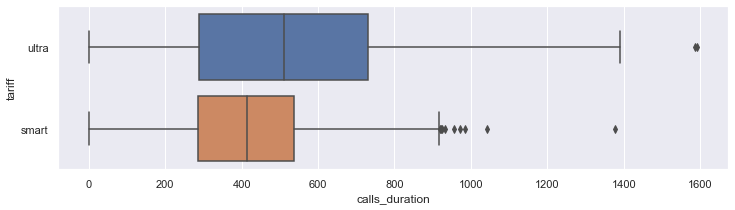

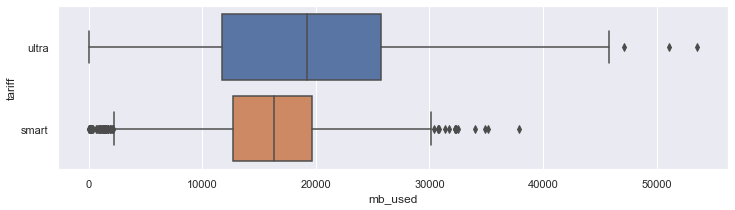

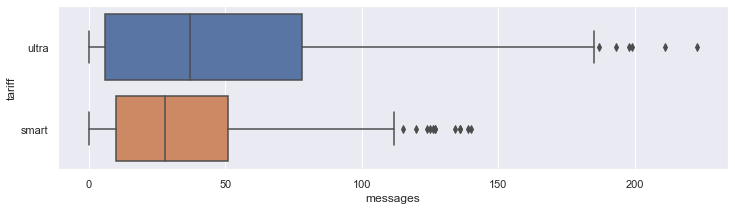

In [29]:
def boxplot_func(x, y='tariff', data=user_month):
    '''Строит boxplot по заданному столбцу x.
    '''
    sns.boxplot(x=x, y=y, data=data)
    plt.show()

for col in ['calls_duration', 'mb_used', 'messages']:
    boxplot_func(col)

Избавимся от выбросов - ограничения поставим по лимитам тариффа ультра

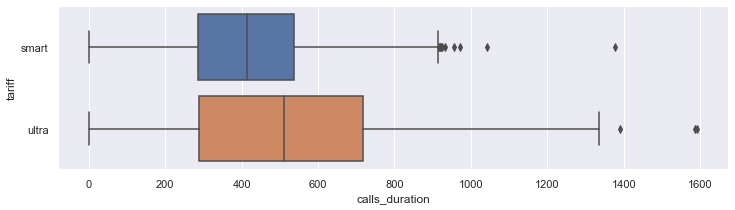

In [30]:
good_ultra = (user_month
              .query('tariff == "ultra" and calls_duration < 3000')
              .query('mb_used < 30000')
              .query('messages < 1000')
             )
good_smart = (user_month
              .query('tariff == "smart" and calls_duration < 3000')
              .query('mb_used < 30000')
              .query('messages < 1000')
             )
good_user_month = good_smart.append(good_ultra)
boxplot_func('calls_duration', data=good_user_month)

In [31]:
print('Убрали наблюдений ultra:', len(user_month[user_month['tariff'] == 'ultra']) - len(good_ultra))
print('Убрали наблюдений smart:', (len(user_month[user_month['tariff'] == 'smart']) - len(good_smart)))
print('Убрали наблюдений из всего датасета df: {:.2%}'.format(((len(good_ultra)+len(good_smart)) / (len(user_month)) - 1)))

Убрали наблюдений ultra: 135
Убрали наблюдений smart: 16
Убрали наблюдений из всего датасета df: -4.64%


### Вытащим месяц

In [32]:
dates_column = ['reg_date', 'churn_date']

for column in dates_column:
    extract_month(good_user_month, column)
    extract_month(df, column)

<a id='2'></a>
# Этап 2. Анализ данных

### Посмотрим как люди регистрировались и уходили в течение года

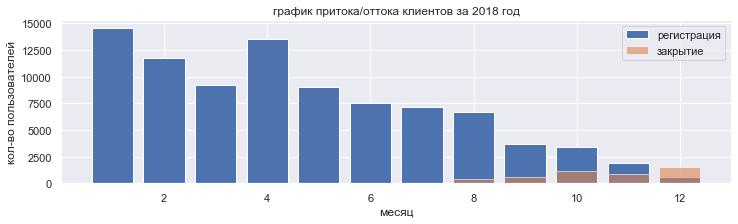

In [33]:
reg_churn_graph(df)

Или это просто такая выборка, или вырисовывается плохая динамика притока новых клиентов.  
Возможно есть некая сезонность и люди охотнее регистрируются в начале года. Нужно посмотреть на динамику за 3-4 года.  
Или это точка роста, и компании стоит задуматься над новой маркетинговой копанией.  

smart


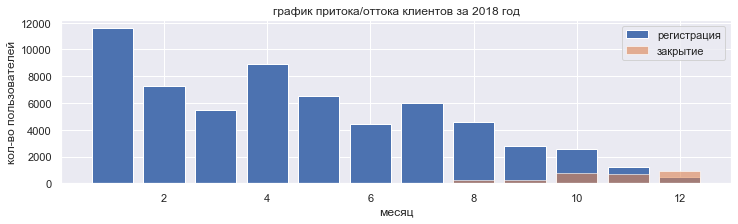

ultra


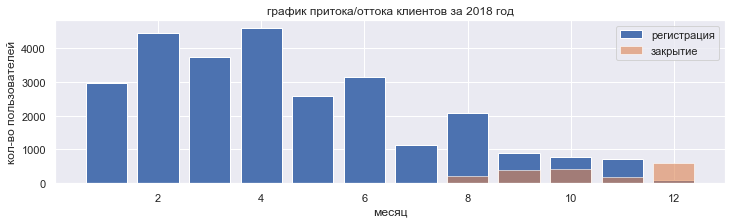

In [34]:
print('smart')
reg_churn_graph(df[df['tariff'] == 'smart'])

print('ultra')
reg_churn_graph(df[df['tariff'] == 'ultra'])

В основном динамика схожа у двух тарифов, но с ultra ушло больше пользователей. Возможно что-то не так с этим тарифов или эти пользователи сменили тариф на смарт.

## Сведем данные к тариф-месяц

In [35]:
tariff_month = good_user_month \
.pivot_table(index=['tariff', 'month'], 
             values=['calls_duration', 'calls_qty', 'mb_used', 'messages', 'revenue_per_month']) \
.reset_index()
tariff_month.sample(2)

,tariff,month,calls_duration,calls_qty,mb_used,messages,revenue_per_month
20,ultra,9,564.466019,78.524272,17786.951456,55.349515,1950.000000
4,smart,5,431.290780,60.921986,16983.127660,36.283688,1253.602837


In [36]:
numeric_columns.append('revenue_per_month')
numeric_columns

['calls_duration', 'calls_qty', 'messages', 'mb_used', 'revenue_per_month']

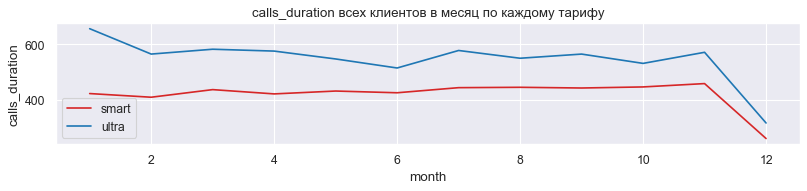

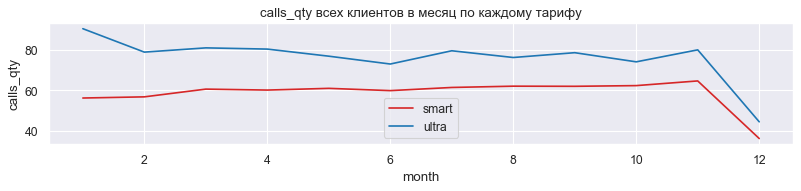

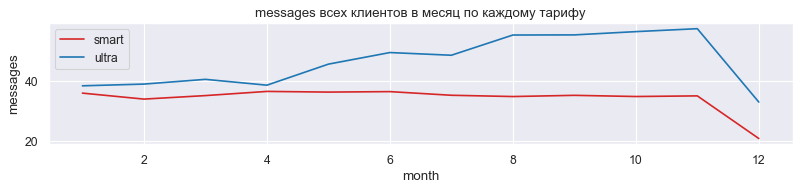

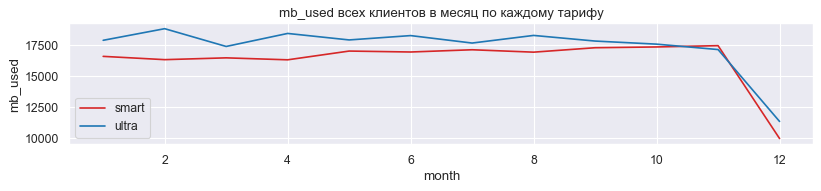

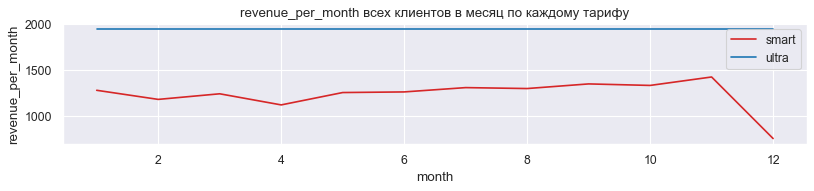

In [37]:
numeric_columns
for column in numeric_columns:
    x = [int(i) for i in range(1,13)]
    y1 = tariff_month[tariff_month['tariff'] == 'smart'][column]
    y2 = tariff_month[tariff_month['tariff'] == 'ultra'][column]

    # Plot Line1 (Left Y Axis)
    fig, ax1 = plt.subplots(1, 1 ,figsize=(12,2), dpi= 80)
    ax1.plot(x, y1, color='tab:red', label='smart')
    plt.ylabel(column)
    plt.xlabel('month')
    plt.title(f'{column} всех клиентов в месяц по каждому тарифу')

    # Plot Line2 (Right Y Axis)
    ax2 = ax1  # instantiate a second axes that shares the same x-axis
    ax2.plot(x, y2, color='tab:blue', label='ultra')
    plt.legend()
    plt.show()

Среденемесячная выручка с Ультра выше, а смартовцы в среднем ежемесечно переплачивают абонентскую плату.

В срднем пользоватали тарифа смарт выходят за пределы лимита по всем видам связи, тогда как в ультра в среднем не используют и половины лимита, особенно это заметно в смс. Возможно поэтому и отток из ультра больше ввиду того, что людям просто не нужен такой объем трафика.  

Кажется, что в декабре не так много трафика, это связано с тем, что точка отсчета у всех пользователей разная и часть данных учитывается в пользу предыдущего месяца.   
Также нужно учитывать что кол-во новых пользователей с каждым месяцем увеличивается, поэтому низкие показатели смс в марте-апреле может быть не информативны.  
  
Рассмотрим как в сумме менялся трафик за последние два месяца:  

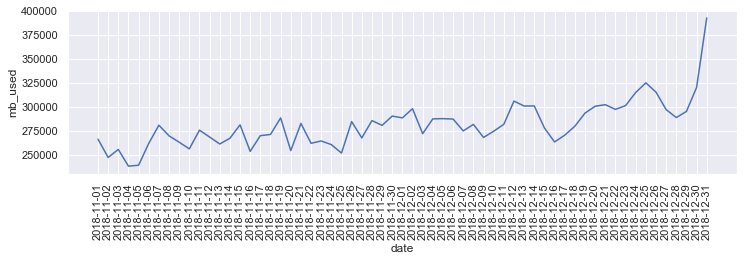

In [38]:
groupped = df.groupby('date')[['mb_used']].sum().reset_index()
groupped['month'] = pd.DatetimeIndex(pd.to_datetime(groupped['date'])).month

x = groupped[(groupped['month'] == 11) | (groupped['month'] == 12)]['date'].unique()
plt.plot(x, groupped[(groupped['month'] == 11) | (groupped['month'] == 12)]['mb_used'])
plt.ylabel('mb_used')
plt.xlabel('date')
plt.xticks(rotation=90)
plt.show()

Под Новый Год виден явный пик

Распределение трафика в течение дня


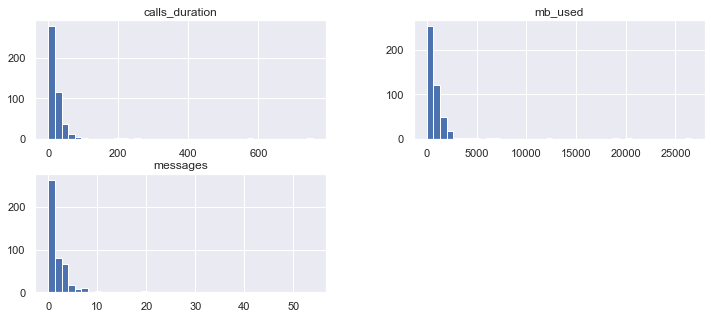

In [39]:
print('Распределение трафика в течение дня')
df[(df['date'] == '2018-12-31')][['calls_duration', 'messages', 'mb_used']].hist(bins=40, figsize=(12,5))
plt.show()

Распределение трафика в течение дня исключая 0


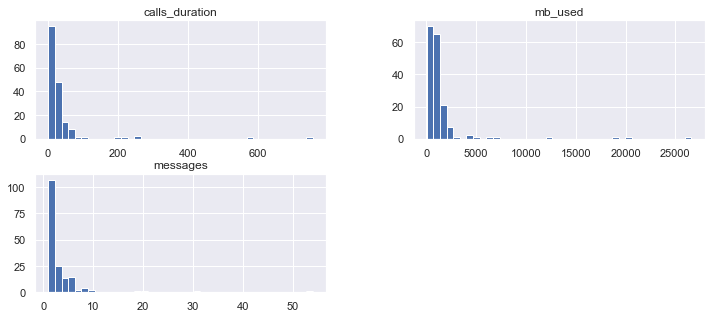

In [40]:
print('Распределение трафика в течение дня исключая 0')
df[(df['date'] == '2018-12-31')
   & (df['calls_duration'] > 0)
   & (df['messages'] > 0)
   & (df['mb_used'] > 0)][['calls_duration', 'messages', 'mb_used']].hist(bins=40, figsize=(12,5))
plt.show()

Много коротких звонков с продолжительностью 0, также не понятно что значит интернет сессии 0 Мб.  
В среднем клиенты "Мегалайн" разговаривают 20 мин в день. Чаще всего отрпавлюят 1 смс и используют до 1.5Гб за день.

## Посчитаем среднее, дисперсию и стандартное отклонение для выборки

In [41]:
variance_estimate = np.var(tariff_month['revenue_per_month'])  # дисперсия для выборки
sd = np.std(tariff_month['revenue_per_month'])  # стандартное отклонение для выборки
mean = tariff_month['revenue_per_month'].mean()  # среднее

print('Дисперсия по выручке для выборки {:.2f}'.format(variance_estimate))
print('Стандартрое отклонение по выручке для выборки {:.2f}'.format(sd))
print('Среднее по выручке для выборки {:.2f}'.format(mean))
print()

tariff_month.describe()

Дисперсия по выручке для выборки 142029.52
Стандартрое отклонение по выручке для выборки 376.87
Среднее по выручке для выборки 1591.20



,month,calls_duration,calls_qty,mb_used,messages,revenue_per_month
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,6.500000,482.838085,67.296743,16811.959955,40.319161,1591.199604
std,3.526299,92.156763,12.766053,2020.520229,9.087568,384.973651
min,1.000000,260.189333,36.157333,9957.338667,20.810667,752.266667
25%,3.750000,429.730355,60.426948,16810.541877,35.092517,1273.681794
50%,6.500000,452.101281,63.427940,17282.142145,36.475323,1686.642395
75%,9.250000,564.480467,78.595585,17802.213592,46.341447,1950.000000
max,12.000000,656.000000,90.375000,18780.476190,57.418182,1950.000000


Посмотрим на статистики двух тарифов

In [42]:
tariff_month.pivot_table(index='tariff', values='revenue_per_month', 
                         aggfunc=['mean', 'median', 'std', 'var']).round(2)

,mean,median,std,var
,revenue_per_month,revenue_per_month,revenue_per_month,revenue_per_month
tariff,,,,
smart,1232.4,1269.25,170.29,29000.27
ultra,1950.0,1950.00,0.00,0.00


Видно что у тарифа ultra разброс выручки меньше, а средняя выручка выше

## Построим гистограммы и опишем распределение

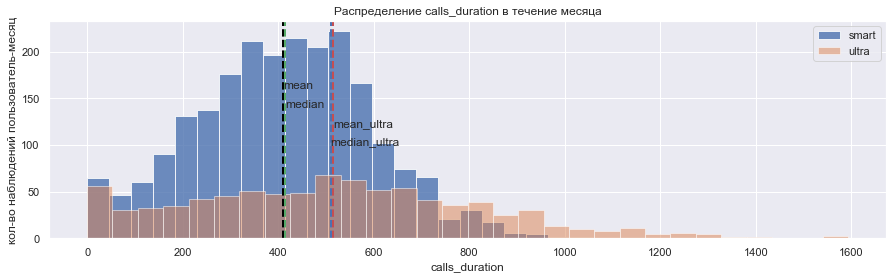

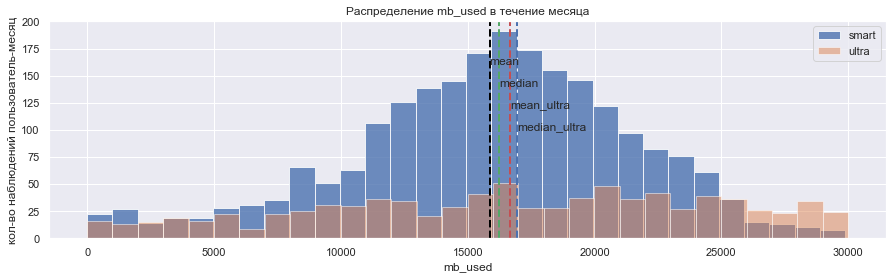

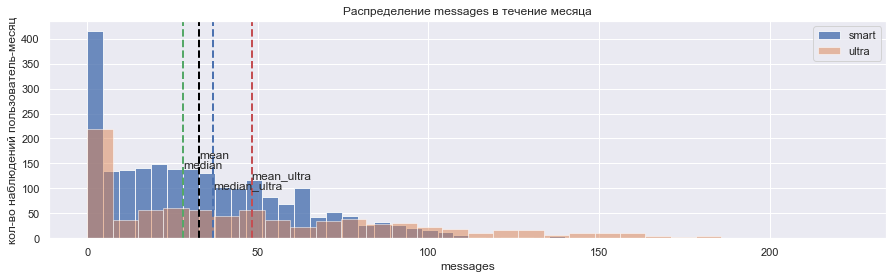

In [43]:
sns.set(rc={'figure.figsize': (15,4)})
for col in ['calls_duration', 'mb_used', 'messages']:
    ax = plt.gca()
    ax.hist(good_user_month[good_user_month['tariff'] == 'smart'][col].values, alpha=0.8, bins=30)
    ax.hist(good_user_month[good_user_month['tariff'] == 'ultra'][col].values, alpha=0.5, bins=30)
    ax.legend(['smart','ultra'])
    ax.set_title('Распределение ' + col + ' в течение месяца')
    
    plt.axvline(good_user_month[good_user_month['tariff'] == 'smart'][col].mean(), 
                color='black', linewidth='2', linestyle='dashed')
    plt.axvline(good_user_month[good_user_month['tariff'] == 'smart'][col].median(), 
                color='g', linewidth='2', linestyle='dashed')
    ax.text(good_user_month[good_user_month['tariff'] == 'smart'][col].mean(), 160, 'mean')
    ax.text(good_user_month[good_user_month['tariff'] == 'smart'][col].median(), 140, 'median')
    
    plt.axvline(good_user_month[good_user_month['tariff'] == 'ultra'][col].mean(), 
                color='r', linewidth='2', linestyle='dashed')
    plt.axvline(good_user_month[good_user_month['tariff'] == 'ultra'][col].median(), 
                color='b', linewidth='2', linestyle='dashed')
    ax.text(good_user_month[good_user_month['tariff'] == 'ultra'][col].mean(), 120, 'mean_ultra')
    ax.text(good_user_month[good_user_month['tariff'] == 'ultra'][col].median(), 100, 'median_ultra')
    
    plt.xlabel(col)
    plt.ylabel('кол-во наблюдений пользователь-месяц')
    
    plt.show()

Распределения для звонков и интернета нормальные

## Сравним среднюю выручку тарифов по месяцам

In [44]:
good_user_month[['month', 'tariff', 'revenue_per_month']] \
.pivot_table(index='month', columns='tariff', values='revenue_per_month', margins=True) \
.style.bar()

tariff,smart,ultra,All
month,,,
1,1278.117647,1950.000000,1406.095238
2,1178.879310,1950.000000,1383.860759
3,1239.961039,1950.000000,1448.412844
4,1118.776786,1950.000000,1360.778481
5,1253.602837,1950.000000,1449.020408
6,1260.374233,1950.000000,1469.619658
7,1307.365000,1950.000000,1484.322464
8,1297.240343,1950.000000,1480.577160
9,1347.700389,1950.000000,1520.025000


In [45]:
print('Выручка по тарифу смарт за 2018 год составила:', good_user_month[good_user_month['tariff'] == 'smart']['revenue_per_month'].sum())
print('Выручка по тарифу ультра за 2018 год составила:', good_user_month[good_user_month['tariff'] == 'ultra']['revenue_per_month'].sum())

Выручка по тарифу смарт за 2018 год составила: 2731517
Выручка по тарифу ультра за 2018 год составила: 1673100


Средняя выручка в месяц по тарифу `ultra` выше, но смарт более популярный и в сумме за 2018 принес больше денег

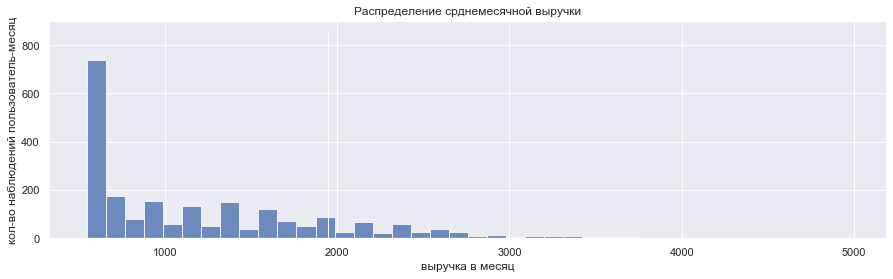

In [46]:
smart = good_user_month[good_user_month['tariff'] == 'smart']
ultra = good_user_month[good_user_month['tariff'] == 'ultra']

smart['revenue_per_month'].hist(bins=40,alpha=0.8)
ultra['revenue_per_month'].hist(bins=40)
plt.xlabel('выручка в месяц')
plt.ylabel('кол-во наблюдений пользователь-месяц')
plt.title('Распределение срднемесячной выручки')
plt.show()

Рассмотрим среднемесячную выручку в Москве, Санкт-Петербурге и других городах

In [47]:
good_user_month[['city_group', 'tariff', 'revenue_per_month']] \
.pivot_table(index='city_group', columns='tariff', values='revenue_per_month', margins=True) \
.style.bar()

tariff,smart,ultra,All
city_group,,,
Москва,1180.148718,1950.000000,1432.341379
Санкт-Петербург,1353.563981,1950.000000,1458.406250
другие,1205.620522,1950.000000,1409.914978
All,1215.087633,1950.000000,1418.099485


Интересно, что в Питере средняя выручка в месяц выше, чем в других городах. Дальше проверим случайно ли это.  

## Вывод

- Есть тревожные показатели в динамике притока новых клиентов. Нужно выгрузить выборки за 3-4 года и посмотреть прослеживается ли сезонность по году. А может мы увидем, что есть проблемы с привлечением новых пользователей.  
- Наименнее популярный вид связи - смс, а наиболее популярный - интернет
- Большая часть пользователей из Москвы, но среднемесячная выручка больше в Питере
- Более чем в 50% наблюдений тарифа смарт есть перерасход лимита, тогда как в ультра пользователи используют больше трафика но не достигая лимита
- Среднемесячная вырчка смарт с одного пользователя составляет примерно 1200 руб, а тарифа ультра - 2000 руб.

<a id='4'></a>
# Этап 4. Проверка гипотез

## Средняя выручка пользователей тарифов «Ультра» и «Смарт»
Сформулируем нулевую гипотезу **Но** так, чтобы использовать знак равенста: *«Среднии выручки пользователей тарифов «Ультра» и «Смарт» равны»*. Исходя из Но сформулируем альтернативную гипотезу **Н1**: *«Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается»*.

### 1. Проверяем нормальность распределения с помощью QQ-plot

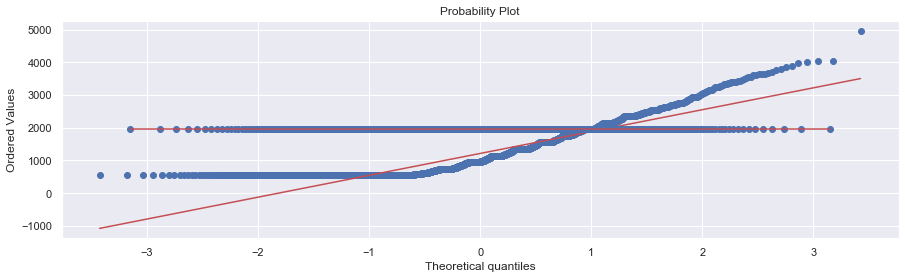

In [48]:
st.probplot(good_smart['revenue_per_month'], plot=sns.mpl.pyplot)
st.probplot(good_ultra['revenue_per_month'], plot=sns.mpl.pyplot)
plt.show()

Большинство точек не попадает на прямую, не похоже на нормальную тенденцию, следует проветси другие тесты нормальности

### 2. Проверяем дисперсию с помощью критерий Фишера и в соответствии с этим корректируем параметр equal_var

In [49]:
test = good_user_month.groupby('tariff')[['calls_duration','revenue_per_month']].mean()
oddsratio, pvalue = st.fisher_exact(test, alternative='two-sided')
print(oddsratio, pvalue)

1.2777178472971353 0.0013289334760626399


### 3. Проводим статистический тест

Для сравнения мат. ожидания между двумя выборками используем Т-критерий Стьюдента.

Сформулируем нулевую гипотезу **Но** так, чтобы использовать знак равенста: *«Среднии выручки пользователей тарифов «Ультра» и «Смарт» равны»*. Исходя из Но сформулируем альтернативную гипотезу **Н1**: *«Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается»*.

Чтобы проверить гипотезу о равенстве средних двух генеральных совокупностей по взятым из них выборкам, используем метод `scipy.stats.ttest_ind (array1, array2, equal_var)`.

Преположительно выборки взяты из схожих по параметрам совокупностей, поэтому оставим параметр equal_var = True.

In [50]:
alpha = 0.01  # критический уровень статистической значимости
              # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(good_smart['revenue_per_month'], good_ultra['revenue_per_month'])

print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.534750679965596e-172
Отвергаем нулевую гипотезу


Уровень значимости очень мал, поэтому отвергаем нулевую гипотезу о равенстве средней выручке двух тарифов. 

## Средняя выручка пользователей из Москвы и других регионов

* Сравним Москву и Питер  
H0: Средняя выручка пользователей из Москвы и Питера одинаковая.    
Н1: Средняя выручка пользователей из Москвы и Питера различается.   

In [51]:
Moscow = good_user_month[good_user_month['city_group'] == 'Москва']
St_Petersburg = good_user_month[good_user_month['city_group'] == 'Санкт-Петербург']
other_city = good_user_month[good_user_month['city_group'] == 'другие']

alpha = 0.01  # критический уровень статистической значимости
              # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(Moscow['revenue_per_month'], St_Petersburg['revenue_per_month'])

print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.6163698838077878
Не получилось отвергнуть нулевую гипотезу


* Сравним Москву и другие города  
H0: Средняя выручка пользователей из Москвы и других городов одинаковая.     
Н1: Средняя выручка пользователей из Москвы и других городов различается.   

In [52]:
alpha = 0.01  # критический уровень статистической значимости
              # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(Moscow['revenue_per_month'], other_city['revenue_per_month'])

print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4847195170525267
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что хотя средняя выручка Москвы, Питера и других городов неодинакова, с вероятностью в почти 30% такое или большее различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними выручками.

<a id='5'></a>
# Общие Выводы

По результатам статистических тестов, нам не удалось подтвердить гипотезу о равенстве средней выручки двух тарифов и можно с большой вероятностью говорить о наличии разницы между этими двумя тарифами. Также не удалось отвергнуть гипотезу о равенстве средней выручки в Москве и регионах.

Больше чем в 50% наблюдений тарифа Смарт переплата составляет более 400руб, тогда как пользователи Ультра не расходуют и половины лимита. Если учесть, что на каждого пользователя тарифа ультра приходится 2 пользователя тарифа смарт, а также учитывая большой отток клиентов из тарифа ультра, можно сказать что смарт выглядит более привлекательным для пользователей вне зависимости от региона.

При этом стоит учитывать, что среднемесячная выручка с Ультра выше почти в два раза. Плюс зная, что пользователям тарифа Смарт не хватает лимитов, возможно стоит начать рекламную компанию с этого тарифа.